# Rank Candidates

Take candidates from EnhDesign notebook, marginalize over different background with held-out model folds and rank them.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm
from matplotlib.patches import Rectangle
import pyBigWig

import sys
sys.path.append("/users/surag/kundajelab/retina-models/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data, get_seq, get_cts
from utils.shap_utils import shuffle_several_times, combine_mult_and_diffref

import shap
import glob
tf.compat.v1.disable_eager_execution()

from metrics import softmax 
import scipy.stats
import joblib

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
def get_profile(output):
    prof, cts = output
    return softmax(prof)*(np.exp(cts)-1)

## Load Models

In [4]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [5]:
models = defaultdict(dict)
ctypes = []
FOLDS = 5

with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    for x in glob.glob("/srv/scratch/surag/tmp/retina/models/20220202_bpnet/fold0/*.h5"):
        ctype = x.split("/")[-1].split(".")[0]
        ctypes.append(ctype)
        print(ctype)
        
        for i in range(FOLDS):
            models[ctype][i] = tf.keras.models.load_model(x.replace("fold0", "fold" + str(i)))

Rod
OFFconebipolar
Retinalganglioncell
Horizontal
AIIamacrine
Microglia
Glyamacrine
Mullerglia
GABAamacrine
ONconebipolar
Astrocyte
Cone
Rodbipolar


In [6]:
len(ctypes)

13

In [7]:
model_count_explainers = defaultdict(dict)

# explainers
for x in ctypes:
    for i in range(FOLDS):
        model_count_explainers[x][i] = shap.explainers.deep.TFDeepExplainer(
                (models[x][i].input,
                 tf.reduce_sum(models[x][i].outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [8]:
INP_LEN = models[ctypes[0]][0].input_shape[1]
OUT_LEN = models[ctypes[0]][0].output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

### Load predictions over peak

To map to quantile per model.

In [9]:
peak_preds = joblib.load("./out/peak_preds.joblib")

In [10]:
peak_preds.keys()

dict_keys(['Rod', 'OFFconebipolar', 'Retinalganglioncell', 'Horizontal', 'AIIamacrine', 'Microglia', 'Glyamacrine', 'Mullerglia', 'GABAamacrine', 'ONconebipolar', 'Astrocyte', 'Cone', 'Rodbipolar'])

## Marginalize

### Prepare background sequences to marginalize over

In [11]:
TARGET = "Horizontal"

In [12]:
bg_set = pd.read_csv("/mnt/lab_data3/surag/kundajelab/retina-design/data/filtered_negatives/{}_peakCalls_sorted.gc.neg.bed.filt.neg.bed".format(TARGET),
                         sep='\t', names=['chr','start','end','1','2','3','4','5','6','summit']).sample(100)

bg_set.head()

,chr,start,end,1,2,3,4,5,6,summit
2141,chr1,41586000,41589000,.,.,.,.,.,.,1500
278,chr1,24957000,24960000,.,.,.,.,.,.,1500
61160,chr13,28167000,28170000,.,.,.,.,.,.,1500
35215,chr7,90336000,90339000,.,.,.,.,.,.,1500
88253,chr21,42363000,42366000,.,.,.,.,.,.,1500


In [13]:
IDX=0
bg_seqs = one_hot.dna_to_one_hot([str(hg38[bg_set.iloc[i]['chr']][bg_set.iloc[i]['start'] + bg_set.iloc[i]['summit'] - INP_LEN//2:bg_set.iloc[i]['start'] + bg_set.iloc[i]['summit'] + INP_LEN//2]) \
                                   for i in range(len(bg_set))])

In [14]:
bg_seqs.shape

(100, 2114, 4)

### Predict

Load candidates.

In [15]:
candidates = joblib.load("./out/v1/{}_candidates.joblib".format(TARGET))
candidates.shape

(100, 320, 4)

In [16]:
PRED_FOLDS = [3,4]

In [17]:
preds = defaultdict(lambda : defaultdict(dict))

In [18]:
for idx, cand in enumerate(tqdm(candidates)):
    seqs_w_cand = bg_seqs.copy()
    seqs_w_cand[:, INP_LEN//2 - candidates.shape[1]//2:INP_LEN//2 + candidates.shape[1]//2] = cand
    
    for m in models:
        for fold in PRED_FOLDS:
            preds[idx][m][fold] = models[m][fold].predict(seqs_w_cand)

  0%|          | 0/100 [00:00<?, ?it/s]/users/surag/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|██████████| 100/100 [15:41<00:00,  9.41s/it]


In [19]:
preds_quants = defaultdict(lambda : defaultdict(dict))
for idx in range(len(candidates)):
    for m in models:
        for fold in PRED_FOLDS:
            preds_quants[idx][m][fold] = np.mean([np.mean(peak_preds[m] < x) for x in preds[idx][m][fold][1]])

In [20]:
np.mean(list(preds_quants[0]['Rod'].values()))

0.077841

In [21]:
preds_quants_fold_avg = defaultdict(lambda : dict())
for idx in range(len(candidates)):
    for m in models:
        preds_quants_fold_avg[idx][m] = np.mean(list(preds_quants[idx][m].values()))

In [22]:
gaps = [(i, preds_quants_fold_avg[i][TARGET] - max([v for k,v in preds_quants_fold_avg[i].items() if k!=TARGET])) \
            for i in range(len(candidates))]

In [23]:
sorted(gaps, key=lambda x:-x[1])

[(72, 0.860375),
 (73, 0.8590695000000002),
 (36, 0.8579865),
 (28, 0.8539384999999999),
 (45, 0.8464780000000001),
 (94, 0.8462165000000001),
 (5, 0.8411795000000001),
 (4, 0.8404814999999999),
 (66, 0.8366810000000001),
 (57, 0.8339060000000003),
 (31, 0.8336635),
 (63, 0.832699),
 (53, 0.8274054999999999),
 (46, 0.8231445),
 (95, 0.822196),
 (41, 0.820986),
 (54, 0.820421),
 (98, 0.8202885000000001),
 (71, 0.818402),
 (93, 0.818153),
 (42, 0.8153634999999999),
 (43, 0.8122765),
 (7, 0.805687),
 (11, 0.8041389999999999),
 (80, 0.8030475000000001),
 (8, 0.800367),
 (69, 0.7987255000000001),
 (48, 0.798675),
 (52, 0.7971274999999999),
 (70, 0.793403),
 (20, 0.7927139999999999),
 (13, 0.7902135),
 (17, 0.7895025),
 (32, 0.787517),
 (59, 0.7859115),
 (39, 0.7845865),
 (83, 0.7844595),
 (51, 0.78386),
 (33, 0.7819705),
 (21, 0.7815159999999999),
 (67, 0.77478),
 (86, 0.7744055000000001),
 (3, 0.7733085),
 (30, 0.771902),
 (27, 0.7713429999999999),
 (84, 0.7711554999999999),
 (88, 0.763553),
 (92, 0.7563505000000001),
 (50, 0.7552319999999999),
 (15, 0.7529239999999999),
 (75, 0.7521105),
 (89, 0.751248),
 (96, 0.7428334999999999),
 (37, 0.7402489999999999),
 (14, 0.7285200000000001),
 (78, 0.7274440000000001),
 (87, 0.7254130000000001),
 (25, 0.7251685),
 (1, 0.724548),
 (47, 0.720941),
 (61, 0.7198450000000001),
 (76, 0.7187785000000002),
 (79, 0.7184525),
 (74, 0.7178340000000001),
 (64, 0.7151825000000002),
 (77, 0.7138869999999999),
 (23, 0.7134854999999998),
 (91, 0.7115124999999999),
 (12, 0.710015),
 (26, 0.7077070000000001),
 (24, 0.7072725),
 (65, 0.700375),
 (90, 0.7002505000000002),
 (49, 0.6984614999999998),
 (62, 0.6974005),
 (16, 0.6932019999999999),
 (10, 0.6916049999999999),
 (40, 0.6907995000000002),
 (2, 0.6824295),
 (19, 0.6813075000000002),
 (6, 0.6778185),
 (9, 0.6667635),
 (60, 0.6543085),
 (34, 0.6535390000000001),
 (18, 0.6438855),
 (97, 0.6311114999999998),
 (55, 0.619982),
 (22, 0.6101779999999999),
 (35, 0.6093265000000001),
 (58, 0.6004394999999999),
 (29, 0.5871650000000002),
 (44, 0.47240300000000024),
 (56, 0.4041095),
 (99, 0.17525600000000002),
 (81, -0.04775700000000001),
 (85, -0.076985),
 (0, -0.09824399999999998),
 (68, -0.101791),
 (82, -0.11272549999999999),
 (38, -0.18771649999999998)]

In [26]:
preds_quants_fold_avg[36]

{'Rod': 0.10641,
 'OFFconebipolar': 0.0513365,
 'Retinalganglioncell': 0.033516000000000004,
 'Horizontal': 0.9643965,
 'AIIamacrine': 0.055142500000000004,
 'Microglia': 0.066828,
 'Glyamacrine': 0.053214000000000004,
 'Mullerglia': 0.0557335,
 'GABAamacrine': 0.06516200000000003,
 'ONconebipolar': 0.020085000000000002,
 'Astrocyte': 0.028777499999999998,
 'Cone': 0.0270475,
 'Rodbipolar': 0.0526945}

In [28]:
one_hot.one_hot_to_dna(candidates)[72]

'TAGATGAGGTTGTGAAGGTGCAGACAGCTAGGCTCCTGGTGCACACTGTGTTCTTATTAAACACTATGGTCACAGTTGTCTATTGATTTGGATCCTATTGATTTCCTGCCATTGGCCTCCTCTCTGCACTGCTGCTGCCTGAGGGCAACTCTATTGATTTTCACTCCCCACTCTGATATTGATTTCTTGCAGAGCTGTGTTCTCTGACCCCCTCCTCCTTTCCAGTCCTGCCCTTCCACTCCCTCCGGAGTCATCCTGTGAGGGCTCACAATGGCCTTTTACTTCTCCCCACACAATGAACATGCTGGGAACTTCCACCA'

In [29]:
one_hot.one_hot_to_dna(candidates)[73]

'AGTAATCATCCATTGTATGGATATACCACATTTTGTTTATCTATACAACTGTCAATGGACCCTGGGTTGCTTCCACCTTTTGGCTACTGTGAATAAGATGCTGTGAACATGGGTGTACAACGTCTGTTTTGAGTCTTTGCTTTCACTTCTCTGAGTTTATACCTAGAAGTGAAATTGATAGATCAGCCTGGCTGCCTATGTTTAATTAGTTTTTGTTGCCCTCAGGCAGAGTCTCACTATTGATTTCAGGCTTGAGTGCACTTATTGATTTTTGGCTCACTAAATCAATAGCTTCCCGGGTTCAATCAATTCTCTTGCCT'

In [30]:
one_hot.one_hot_to_dna(candidates)[36]

'AGAGAGAATGAGAGAAATCAATAAGCAGAAAAAATCAATAAAACCATCAGATTGCCCCCAGGCAAATGACTGCCATGAGAACAGAAAAATCAATAGAAAACCATCGACAGCCTGGCTGCATCTCCCACTGGGTCCCTCCCACAATACATGGGAATTATGGGAACTACAATTCAAGGTGAGATTTGGGTGGGGACACAGGCAAACCATATCAAGACCCAAGGCTGTATGTTCAGAGCGAGGTGTGCCAAGCCCTGGGAGACCCACAGCTACCCATCATCGAGGTGCTTCAATGCATGGGTTCAGAGCCTCCTGTCTCCACC'

## Viz Importance

In [37]:
IDX = 36

In [38]:
cur_raw_seqs = np.expand_dims(bg_seqs[0].copy(), 0)
cur_raw_seqs[:, INP_LEN//2 - candidates[IDX].shape[0]//2:INP_LEN//2 + candidates[IDX].shape[0]//2] = candidates[IDX]

# counts_shap_scores = np.array([model_count_explainers[CTYPE1][i].shap_values(cur_raw_seqs) for i in range(FOLDS)]).mean(0)
# projected_shap_scores = np.multiply(cur_raw_seqs, counts_shap_scores)

FOLD=3

proj_scores = {}
for m in models:
    counts_shap = model_count_explainers[m][FOLD].shap_values(cur_raw_seqs)
    proj_scores[m] = np.multiply(cur_raw_seqs, counts_shap)

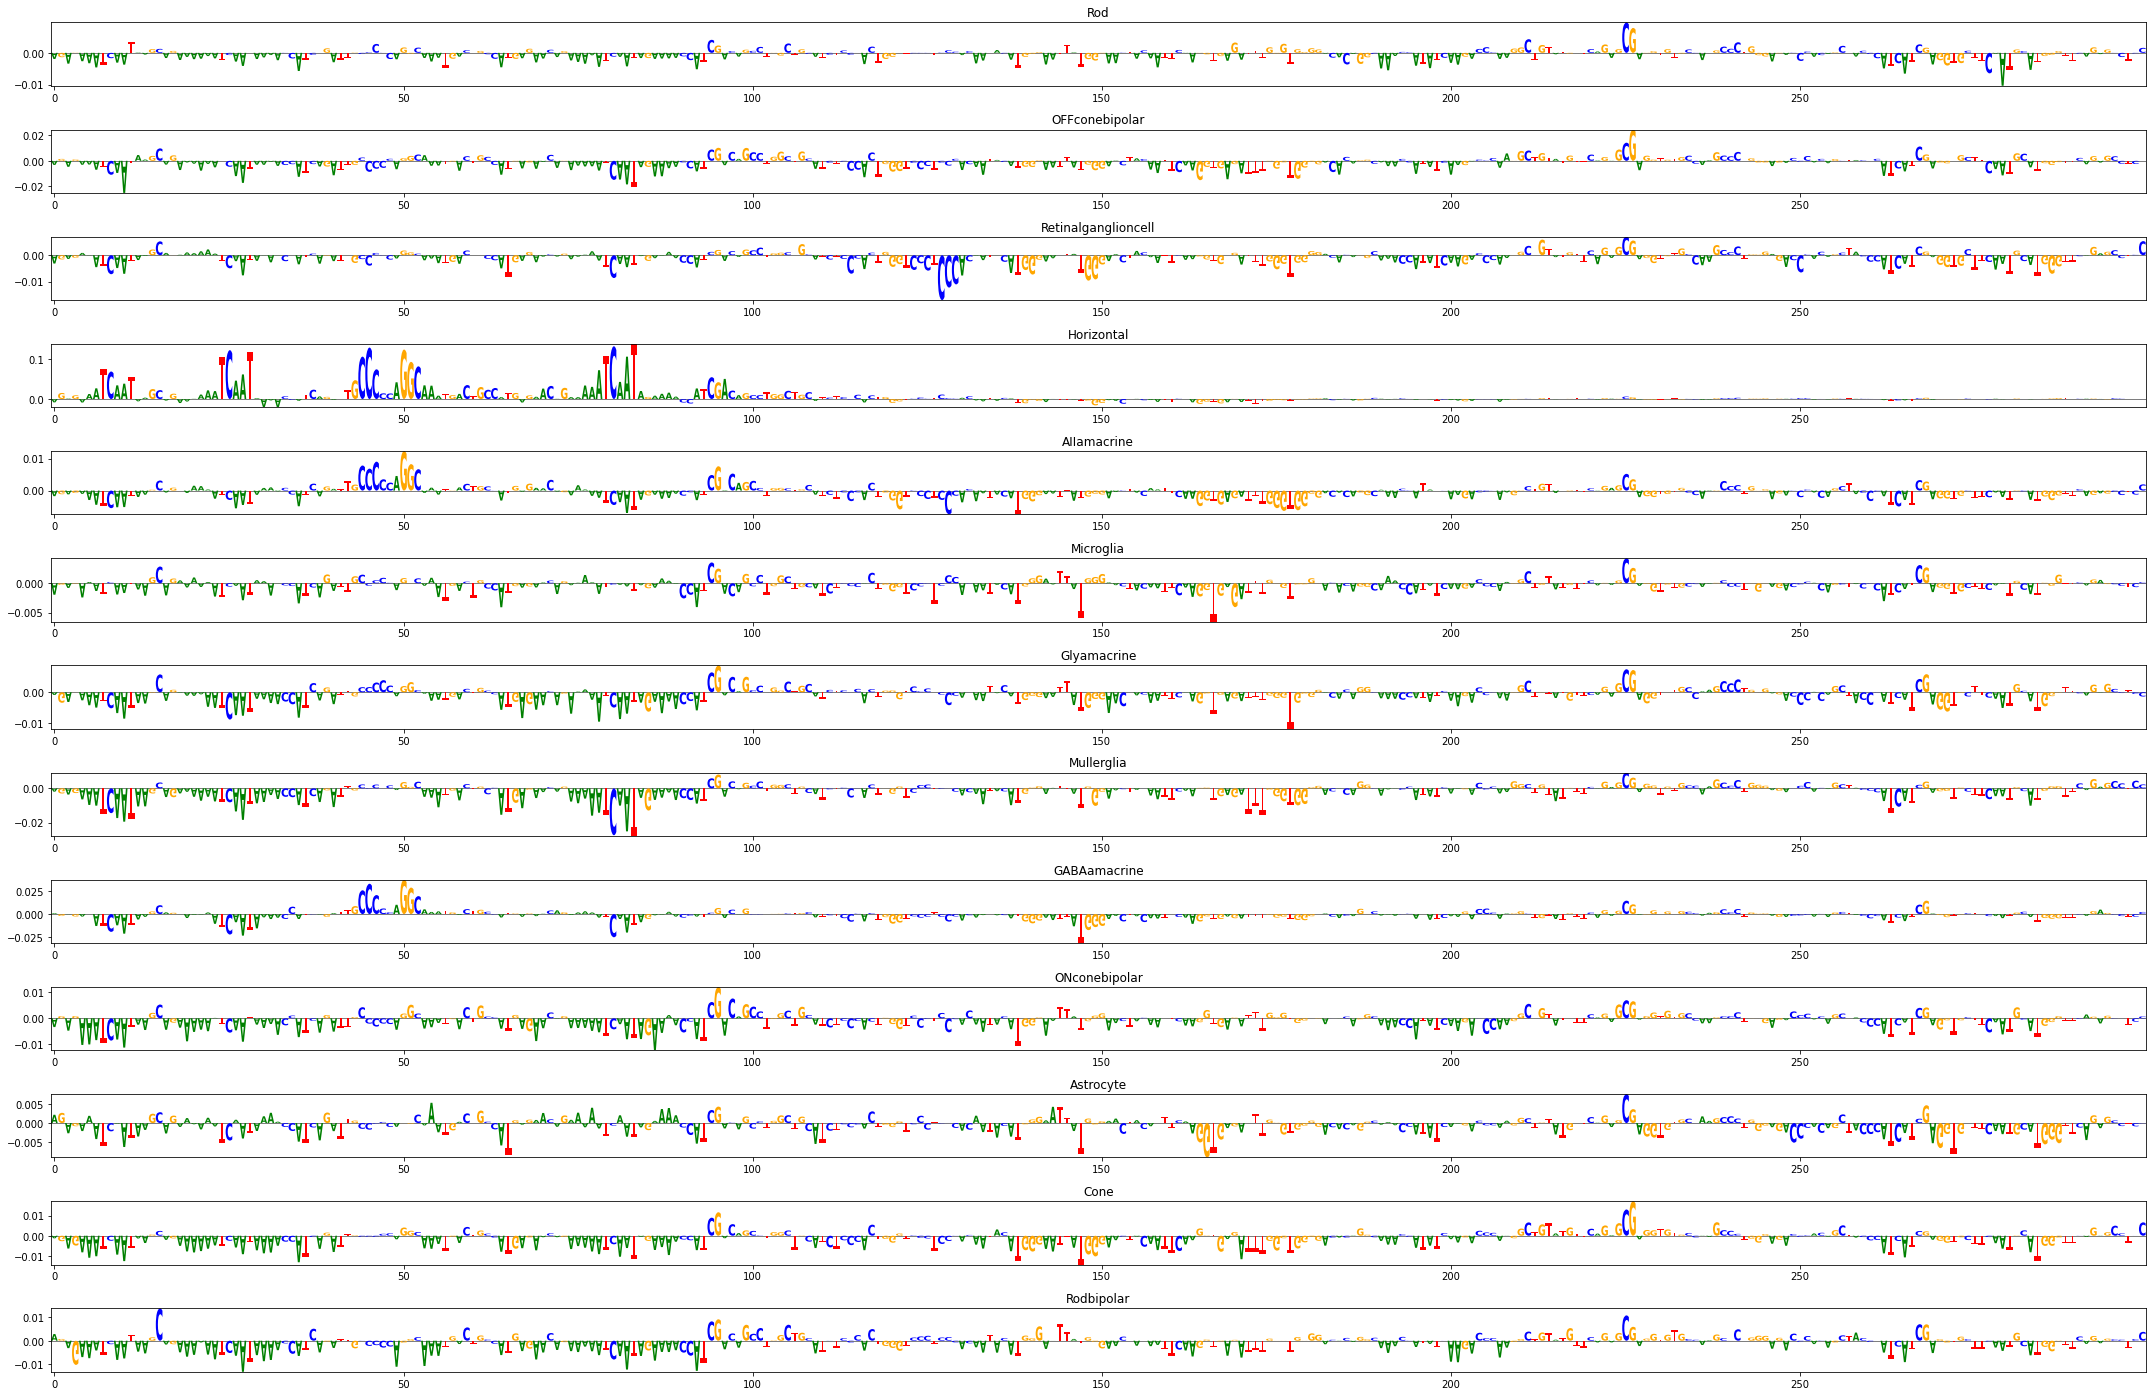

In [39]:
WINDOW = 300
SLICE_START = INP_LEN//2 - WINDOW//2
SLICE_END = INP_LEN//2 + WINDOW//2

fig, ax = plt.subplots(len(models), figsize=(30,1.5*len(models)))

for i,m in enumerate(models):    
    logomaker.Logo(pd.DataFrame(proj_scores[m][0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
                  ax=ax[i])
    ax[i].title.set_text(m)

plt.tight_layout()
plt.show()

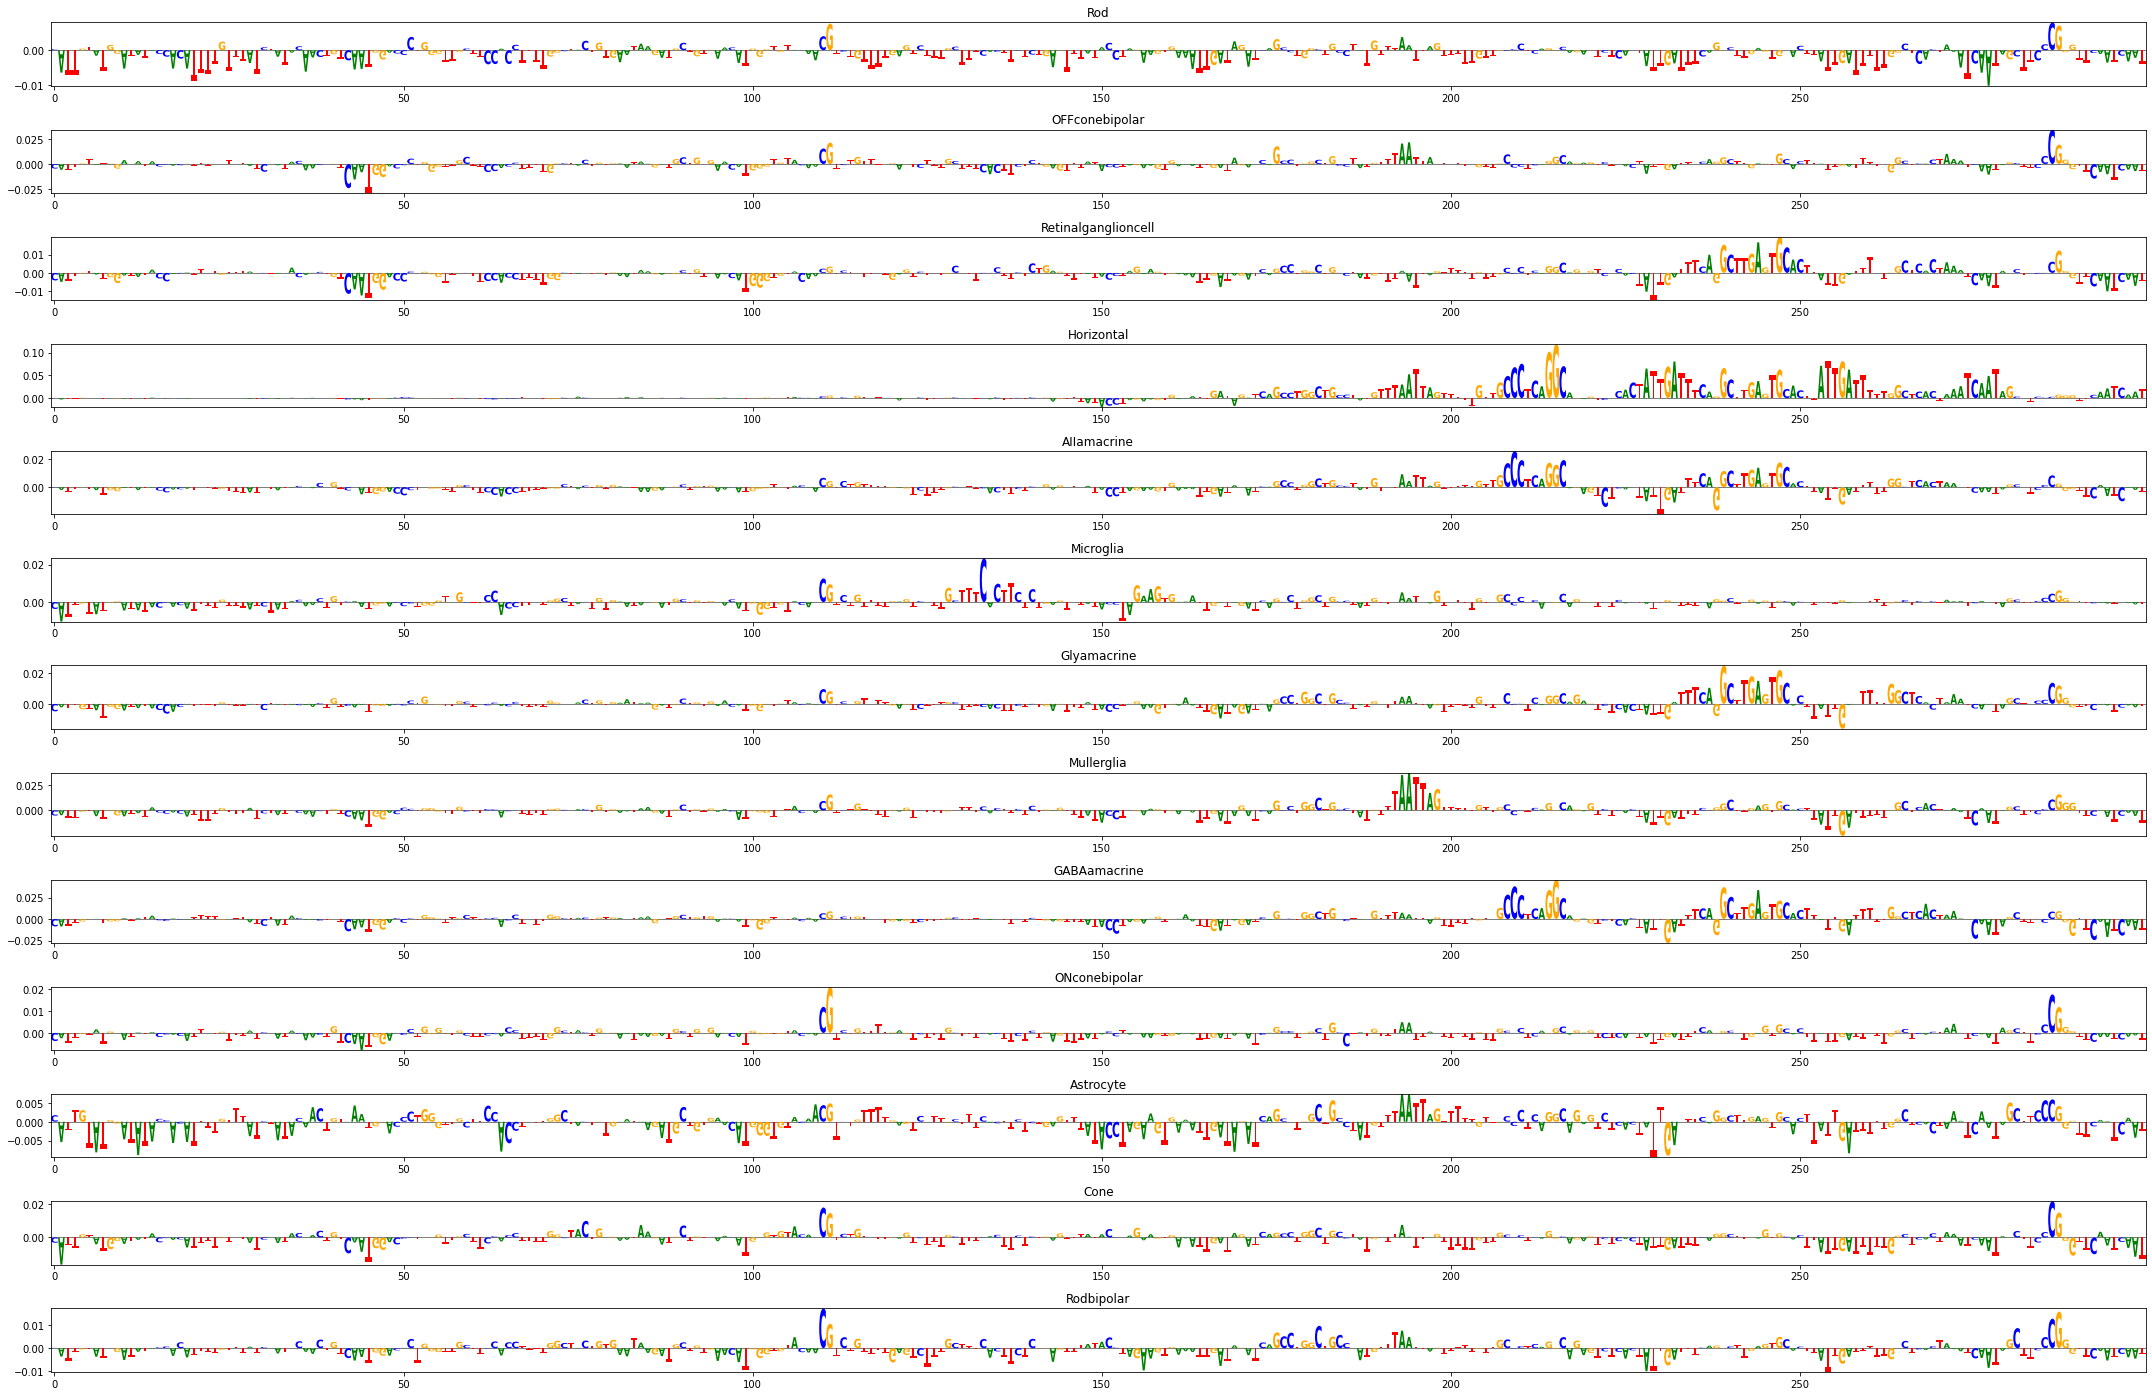

In [36]:
WINDOW = 300
SLICE_START = INP_LEN//2 - WINDOW//2
SLICE_END = INP_LEN//2 + WINDOW//2

fig, ax = plt.subplots(len(models), figsize=(30,1.5*len(models)))

for i,m in enumerate(models):    
    logomaker.Logo(pd.DataFrame(proj_scores[m][0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
                  ax=ax[i])
    ax[i].title.set_text(m)

plt.tight_layout()
plt.show()

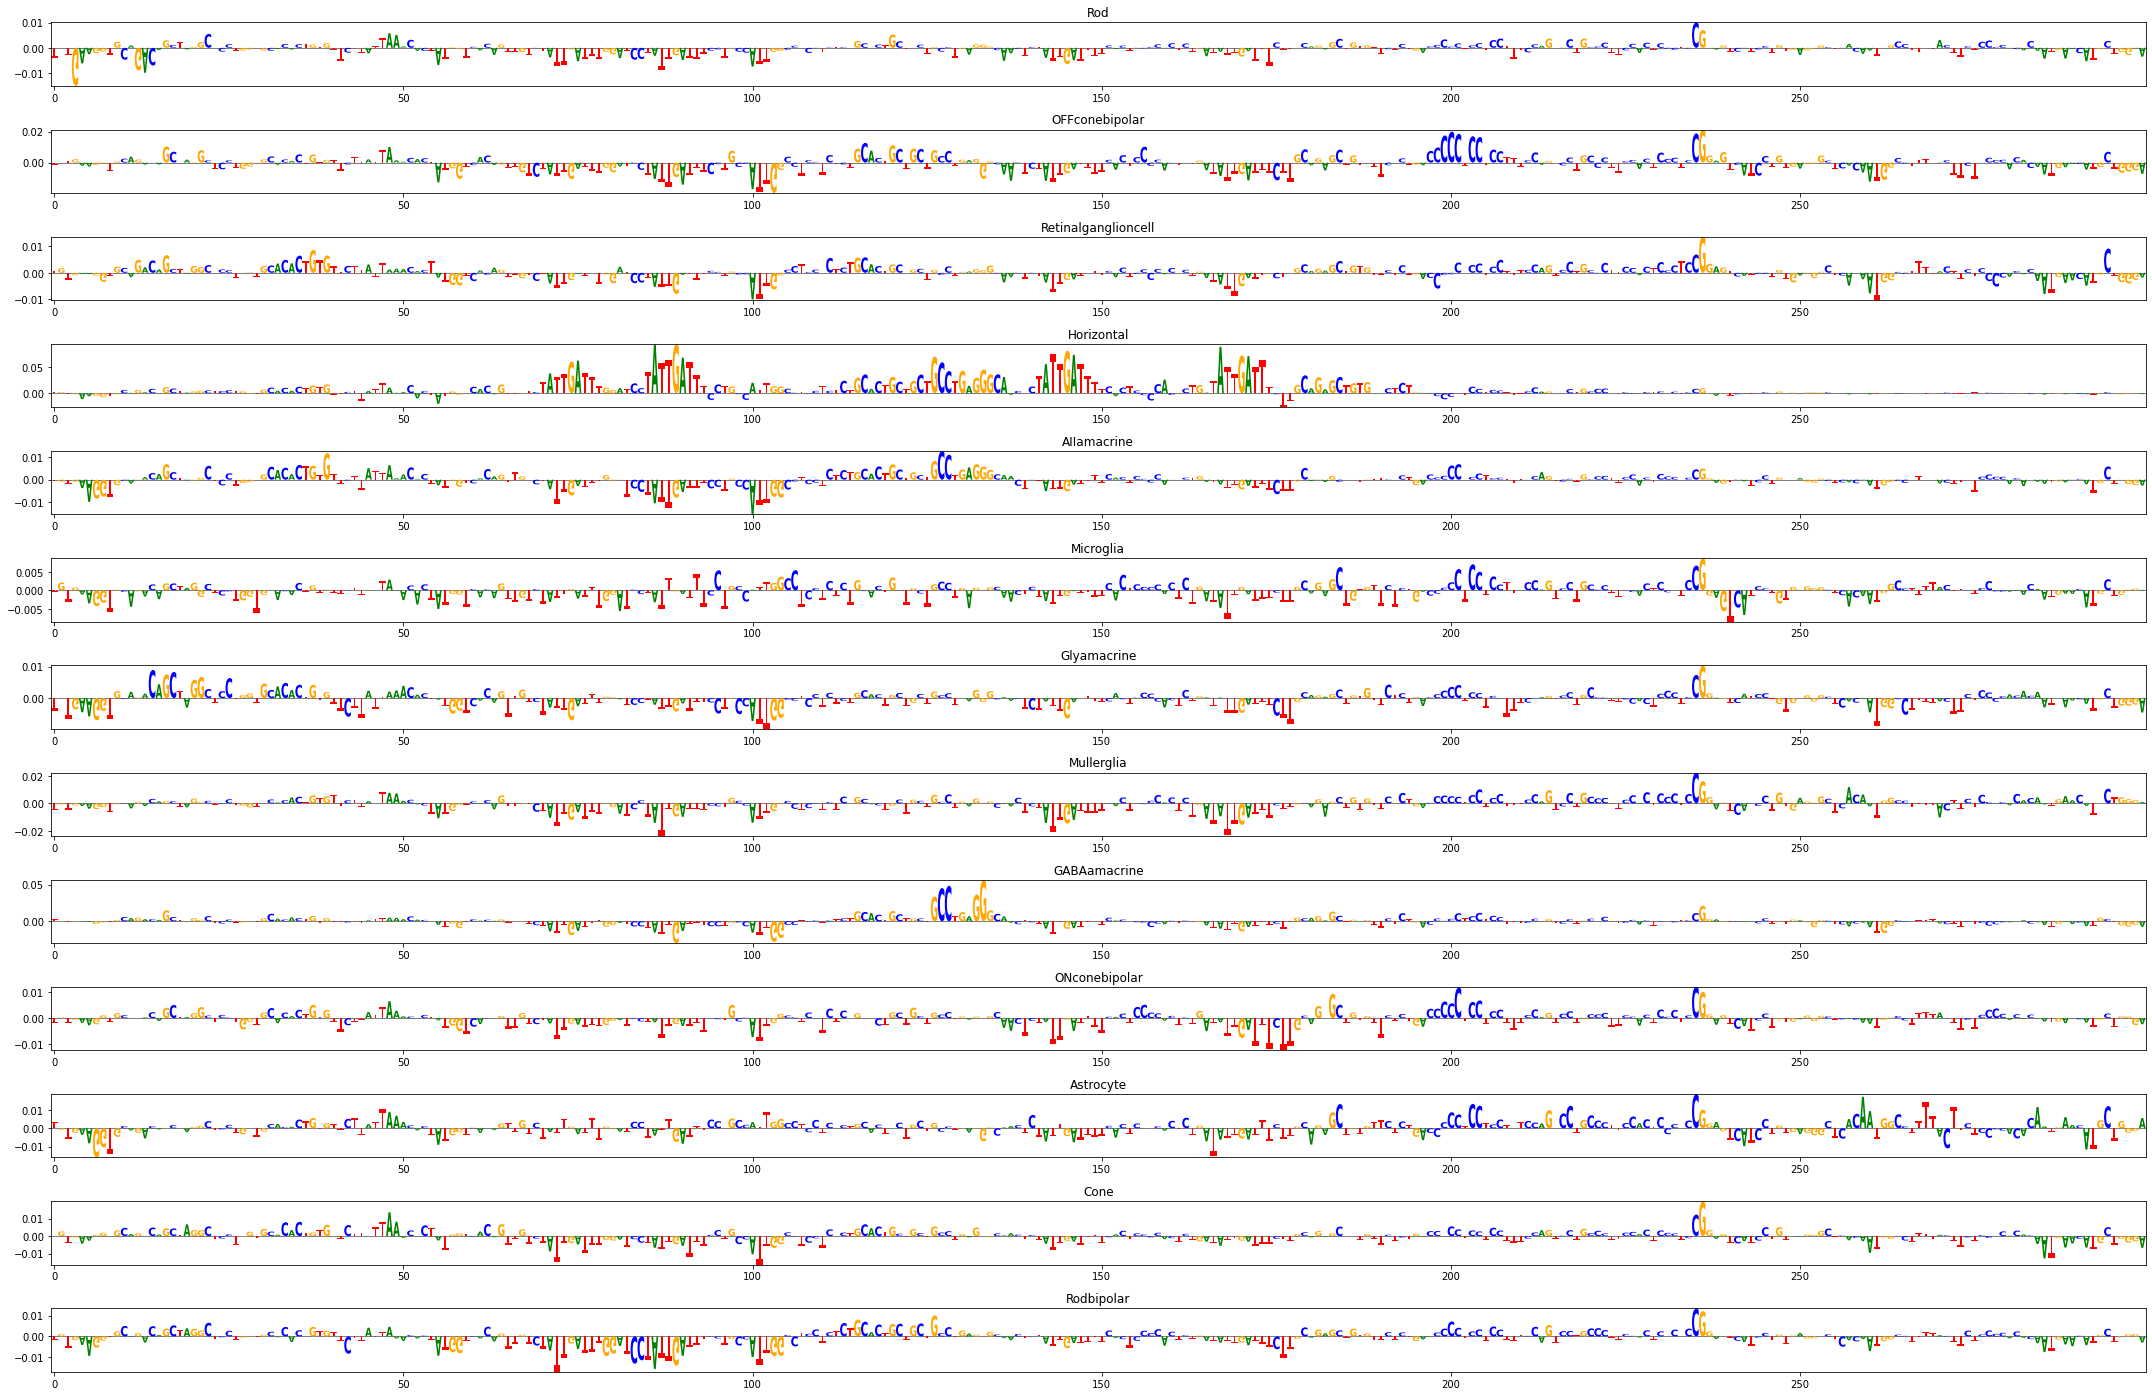

In [33]:
WINDOW = 300
SLICE_START = INP_LEN//2 - WINDOW//2
SLICE_END = INP_LEN//2 + WINDOW//2

fig, ax = plt.subplots(len(models), figsize=(30,1.5*len(models)))

for i,m in enumerate(models):    
    logomaker.Logo(pd.DataFrame(proj_scores[m][0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
                  ax=ax[i])
    ax[i].title.set_text(m)

plt.tight_layout()
plt.show()